In this notebook I produce a discretized version of the quark gluon dataset.

I scale it down to NxN and discretize each pixel to M values.

Parameters:
    
size: N (scale down to NxN)
Nvals: M (M values per pixel)
Nsamples: number of samples to write to the nwe dataset)
file_name: filename of the output dataset

In [1]:
size = 4
Nvals = 4
Nsamples = 100000
file_name = "QG_train_normalized_N4_M4_bilinear_xl"

# which channel to use
channel = 1
# batch size when reading and writing
batch_size = 200

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
import matplotlib
from itertools import product

In [3]:
f = h5py.File("../data/quark-gluon_train-set_n793900.hdf5","r")
x_train = f.get('X_jets')
y_train = f.get('y')

Method to discretize an image to Nvals values per pixel

In [4]:
def discretize_img(img):
    bins = np.linspace(0,1,Nvals+1)
    vals = np.linspace(0,1,Nvals)
    inds = np.digitize(img, bins)
    return vals[inds-1]

crap and resize an image with the given rescale method.
crop fraction gives the percentage of the image to retain after the crop 

In [5]:
def crop_and_resize(x, channel, scale, crop_fraction=0.8, meth="bilinear"):
    cropped = tf.image.central_crop(x[:,:,:,channel].reshape(x.shape[0],125,125,1), crop_fraction)
    return tf.image.resize(cropped, (scale,scale), method=meth).numpy()

In [6]:
scale = size
num_batches = Nsamples//batch_size

events = num_batches*batch_size

fnew = h5py.File(file_name, "w")

dsetx = fnew.create_dataset("X", (events,scale,scale), dtype='f')
dsety = fnew.create_dataset("y", (events,), dtype='i')
 
for i in range(int(num_batches)):
    y = y_train[i * batch_size: (i + 1) * batch_size]
    x = x_train[i * batch_size: (i + 1) * batch_size]
    
    #div1 = np.max(x, axis=(1,2)).reshape((batch_size,1,1,3))
    #div1[div1 == 0] = 1
    #x = x / (div1+0.00001)
    
    x_train_small = crop_and_resize(x, channel, scale, crop_fraction=0.7)#, meth="lanczos5")
    
    div1 = np.max(x_train_small, axis=(1,2)).reshape((batch_size,1,1,1))
    div1[div1 == 0] = 1
    x_train_small = x_train_small / (div1+0.00001)
    
    x_discr = discretize_img(x_train_small)
    
    dsety[i * batch_size: (i + 1) * batch_size] = y
    dsetx[i * batch_size: (i + 1) * batch_size] = x_discr.reshape((x_discr.shape[0], scale, scale))
    print("batch ",i,"/",num_batches, end="\r")
    
fnew.close()

2023-10-04 12:50:25.609694: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-04 12:50:25.609728: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-04 12:50:25.609755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2023-10-04 12:50:25.610113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
fnew.close()

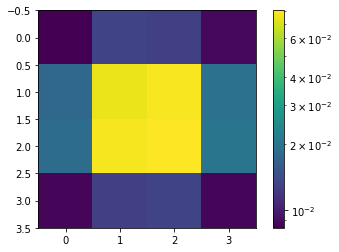

In [8]:
ftest = h5py.File(file_name,"r")
plt.imshow(np.mean(ftest['X'],axis=0),norm=matplotlib.colors.LogNorm())
plt.colorbar()

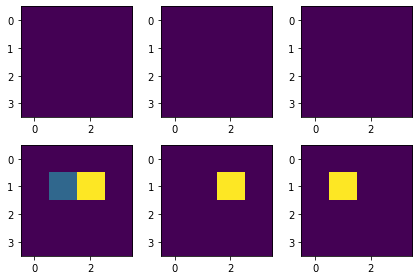

In [13]:
fig, ax = plt.subplots(2, 3)
for i,j in product(range(2),range(3)):
    num = np.random.randint(0,ftest['X'].shape[0])
    ax[i,j].imshow(ftest['X'][num])
fig.tight_layout()

In [14]:
ftest.close()